In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import bemcs

def construct_kernels_centralnode(fileinput,els,kernels_s,kernels_n,traction_kernels_s,traction_kernels_n, matrix_slip):
    
    bctype_x = fileinput["bc_type_x"].values
    bctype_y = fileinput["bc_type_y"].values
    labels = fileinput["collection"].values
    
    n_els = len(els.x1)
    Nunknowns = 6 * n_els

    # Linear operator for central node BCs
    kerneleval_x = np.zeros((n_els, Nunknowns))
    kerneleval_y = np.zeros((n_els, Nunknowns))

    # x,y-kernels
    for i in np.unique(labels):
        index = np.where(labels == i)[0]
        for j in index:
            if bctype_x[j] == "u_global":
                for k in range(0, 3):
                    kerneleval_x[j, k::6] = kernels_s[3][j, k::3]
                    kerneleval_x[j, k + 3 :: 6] = kernels_n[3][j, k::3]
            elif bctype_x[j] == "t_local":
                for k in range(0, 3):
                    kerneleval_x[j, k::6] = traction_kernels_s[0][j, k::3]
                    kerneleval_x[j, k + 3 :: 6] = traction_kernels_n[0][j, k::3]
            elif bctype_x[j] == "s_local":
                kerneleval_x[j, :] = matrix_slip[2::6, :][j, :]
            else:
                raise ValueError("unrecognized boundary condition type")

            if bctype_y[j] == "u_global":
                for k in range(0, 3):
                    kerneleval_y[j, k::6] = kernels_s[4][j, k::3]
                    kerneleval_y[j, k + 3 :: 6] = kernels_n[4][j, k::3]
            elif bctype_y[j] == "t_local":
                for k in range(0, 3):
                    kerneleval_y[j, k::6] = traction_kernels_s[1][j, k::3]
                    kerneleval_y[j, k + 3 :: 6] = traction_kernels_n[1][j, k::3]
            elif bctype_y[j] == "s_local":
                kerneleval_y[j, :] = matrix_slip[3::6, :][j, :]
            else:
                raise ValueError("unrecognized boundary condition type")
            
    return kerneleval_x,kerneleval_y

def extract_quadratic_components(quadratic_coefs,n_els):
    # extract (s,n) components and store them in 2 separate vectors
    quadratic_coefs_s = np.zeros((3 * n_els, 1))
    quadratic_coefs_n = np.zeros((3 * n_els, 1))
    for i in range(n_els):
        quadratic_coefs_s[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i : 6 * i + 3]
        quadratic_coefs_n[3 * i : 3 * (i + 1)] = quadratic_coefs[6 * i + 3 : 6 * (i + 1)]
    
    return quadratic_coefs_s,quadratic_coefs_n


## Main Himalayan Thrust BEM experiment
In this numerical experiment we construct a model of the 2015 Gorkha earthquake that had 4-6 m of coseismic slip along the deeper "flat" structure of the MHT. We compare a traditional constant slip BEM approach with solutions using our new "smooth slip" formulation (`bemcs`)

Going from the quadratic basis function formulation in `bemcs` to constant basis is simple. We take the kernels that we constructed for the quadratic nodes and sum each of the 3 kernel partials to get the constant kernel. Note that these kernels can be either 'slip', 'displacement' or 'traction' kernels. 

In practice, if the quadratic kernel is of the form for 2 fault elements $a$ and $b$:

$K_q = \begin{bmatrix} 
\phi^s_{a1} & \phi^s_{a2} & \phi^s_{a3} & \phi^n_{a1} & \phi^n_{a2} & \phi^n_{a3} & 
\phi^s_{b1} & \phi^s_{b2} & \phi^s_{b3} & \phi^n_{b1} & \phi^n_{b2} & \phi^n_{b3} & ... \\ 
\vdots & & & \vdots & & & \vdots & & & \vdots & & & ...
\end{bmatrix}$

then the constant slip kernel $K_c$ can be computes as:

$K_c = \begin{bmatrix}
\phi^s_{a1} + \phi^s_{a2} + \phi^s_{a3} & \phi^n_{a1} + \phi^n_{a2} + \phi^n_{a3} & 
\phi^s_{b1} + \phi^s_{b2} + \phi^s_{b3} & \phi^n_{b1} + \phi^n_{b2} + \phi^n_{b3} & ... \\
\vdots & \vdots & \vdots & \vdots & ...
\end{bmatrix}$


# Material properties

In [2]:
mu = 1  # TODO: Change to 3e10
nu = 0.25

# BEM solve and evaluate functions

In [3]:
def build_and_solve_bem(file_name, mu, nu, element_type="smooth_slip"):
    # read fault geometry files
    fileinput = pd.read_csv(file_name)

    # print(fileinput.head())
    x1 = fileinput["x1"].values
    x2 = fileinput["x2"].values
    y1 = fileinput["y1"].values
    y2 = fileinput["y2"].values
    bc_x = fileinput["bc_x"].values
    bc_y = fileinput["bc_y"].values
    bctype_x = fileinput["bc_type_x"].values
    bctype_y = fileinput["bc_type_y"].values

    labels = fileinput["collection"].values
    print(np.unique(labels))

    # create bemcs data structure
    els = bemcs.initialize_els()
    els.x1 = x1
    els.y1 = y1
    els.x2 = x2
    els.y2 = y2
    bemcs.standardize_els_geometry(els)
    n_els = len(els.x1)

    # Identifying open nodes, overlapping interior nodes and triple junctions automatically
    index_open, index_overlap, index_triple = bemcs.label_nodes(els)
    N_c = 2 * n_els  # central node equations
    N_o = 2 * len(index_open)  # open node equations
    N_i = 4 * len(index_overlap)  # overlapping node equations
    N_t = 6 * len(index_triple)  # triple junction equations
    Nunknowns = 6 * n_els

    # We will stack this with:
    # 1. Equations for the element centers
    # 2. Equations at open nodes (RHS = 0)
    # 3. Equations at overlapping nodes (RHS = 0)
    # 4, Equations at triple junctions (RHS = 0)
    BC_c = np.zeros((N_c, 1))  # these are the only non-zero entries
    BC_o = np.zeros((N_o, 1))
    BC_i = np.zeros((N_i, 1))
    BC_t = np.zeros((N_t, 1))

    # Apply BCs at central nodes
    BC_c[0::2, 0] = bc_x
    BC_c[1::2, 0] = bc_y

    # Atack all the BCs into one big vector
    BCvector = np.vstack((BC_c, BC_o, BC_i, BC_t))

    # Design Matrix System
    # - At element centers, we implement either displacement, slip or traction boundary conditions
    # - At open nodes, we force slip to be 0
    # - At 2-overlap (interior) nodes we have continuity & smoothness of slip
    # - At triple junctions, we implement 2 equations for conservation of slip and 4 equations for smoothness
    # Design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
    matrix_slip, matrix_slip_gradient = bemcs.get_matrices_slip_slip_gradient(
        els, reference="local"
    )

    # Patch center locations
    # (need to be shifted an infinitesimal amount in unit normal direction for displacement bcs)
    epsilonr = 1e-6 * (bctype_x == "u_global").astype(float)
    obs_xy = np.vstack((els.x_centers, els.y_centers)).T
    x_obs = (obs_xy[:, 0] + epsilonr * els.x_normals).reshape(-1, 1)
    y_obs = (obs_xy[:, 1] + epsilonr * els.y_normals).reshape(-1, 1)

    # Compute shear and tensile stress kernels evaluated ONLY at the center of each element
    kernels_s = bemcs.get_displacement_stress_kernel(x_obs, y_obs, els, mu, nu, "shear")
    kernels_n = bemcs.get_displacement_stress_kernel(
        x_obs, y_obs, els, mu, nu, "normal"
    )

    # Convert to traction kernels [Nobs x Ncoefficients]
    traction_kernels_s = bemcs.get_traction_kernels(els, kernels_s, flag="local")
    traction_kernels_n = bemcs.get_traction_kernels(els, kernels_n, flag="local")

    # Construct linear operator and solve system
    # Linear operators for the appropriate boundary conditions
    matrix_system_c = np.zeros((N_c, Nunknowns))
    kerneleval_x, kerneleval_y = construct_kernels_centralnode(
        fileinput,
        els,
        kernels_s,
        kernels_n,
        traction_kernels_s,
        traction_kernels_n,
        matrix_slip,
    )

    # Populate matrix_system for central nodes
    matrix_system_c[0::2, :] = kerneleval_x
    matrix_system_c[1::2, :] = kerneleval_y
    matrix_system_o, matrix_system_i, matrix_system_t = bemcs.construct_smoothoperator(
        els, index_open, index_overlap, index_triple
    )

    # Stack the matrices and create the full linear operator
    matrix_system = np.vstack(
        (matrix_system_c, matrix_system_o, matrix_system_i, matrix_system_t)
    )

    # Compute quadratic node coefficients (in local (s,n) coordinates)
    coefs = np.linalg.inv(matrix_system) @ BCvector

    if element_type == "constant_slip":
        ### START Paste of stuff for constant slip case
        # # provide new input file for locked system with appropriate BCs
        # bc_x = fileinput["bc_x"].values
        # bc_y = fileinput["bc_y"].values
        BC_constant = np.zeros((N_c, 1))
        BC_constant[0::2, 0] = bc_x
        BC_constant[1::2, 0] = bc_y

        # Linear Operators for the appropriate boundary conditions
        # Note that we now only need to evaluate BCs at the center of each node, so the size of the operator is smaller than before
        matrix_system_constant = np.zeros((N_c, N_c))
        kernelconst_x = np.zeros((n_els, N_c))
        kernelconst_y = np.zeros((n_els, N_c))

        # To construct a constant slip kernel, simply sum the 3 quadratic terms i.e., each set of 3 columns from the original kernels
        for i in range(N_c):
            kernelconst_x[:, i] = np.sum(kerneleval_x[:, i * 3 : 3 * (i + 1)], axis=1)
            kernelconst_y[:, i] = np.sum(kerneleval_y[:, i * 3 : 3 * (i + 1)], axis=1)

        # Populate matrix_system for central nodes
        matrix_system_constant[0::2, :] = kernelconst_x
        matrix_system_constant[1::2, :] = kernelconst_y

        # Compute quadratic node coefficients (in local (s,n) coordinates)
        coefs_constant = np.linalg.inv(matrix_system_constant) @ BC_constant

        # Take constant slip state vector and create quadratic vector with copied constant_coefs values
        coefs = np.zeros((6 * n_els, 1))
        coefs[0::3] = coefs_constant
        coefs[1::3] = coefs_constant
        coefs[2::3] = coefs_constant
        ### END Past of stuff for constant slip case

    return els, coefs


def evaluate_bem_solution(x_obs, y_obs, els, mu, nu, coefs):
    n_els = len(els.x1)

    # Compute shear and tensile stress kernels
    kernels_shear = bemcs.get_displacement_stress_kernel(
        x_obs, y_obs, els, mu, nu, "shear"
    )
    kernels_normal = bemcs.get_displacement_stress_kernel(
        x_obs, y_obs, els, mu, nu, "normal"
    )

    # Quadratic element case
    # extract (s,n) components and store them in 2 separate vectors
    coefs_shear = np.zeros((3 * n_els, 1))
    coefs_normal = np.zeros((3 * n_els, 1))
    for i in range(n_els):
        coefs_shear[3 * i : 3 * (i + 1)] = coefs[6 * i : 6 * i + 3]
        coefs_normal[3 * i : 3 * (i + 1)] = coefs[6 * i + 3 : 6 * (i + 1)]

    # Compute displacement and stresses (we will plot it later)
    ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
        kernels_shear, kernels_normal, coefs_shear, coefs_normal
    )

    strain_energy_plane_strain = bemcs.get_strain_from_stress(
        sxx, syy, sxy, mu, nu, conversion="plane_strain"
    )

    return ux, uy, sxx, syy, sxy, strain_energy_plane_strain

# BEM solve (4 cases)
1. Interseismic smooth slip
2. Interseismic constant slip
3. Coseismic smooth slip
4. Coseismic constant slip

In [4]:
# 1. Interseismic (smooth slip)
input_file_interseismic = "mht_geometry_bcnew_5_km.csv"
els, coefs_interseismic_smooth = build_and_solve_bem(
    input_file_interseismic, mu, nu, element_type="smooth_slip"
)

# 2. Interseismic (constant slip)
els, coefs_interseismic_constant = build_and_solve_bem(
    input_file_interseismic, mu, nu, element_type="constant_slip"
)

# 3. Coseismic (smooth slip)
input_file_coseismic = "mht_geometry_gorkha_5_km.csv"
els, coefs_coseismic_smooth = build_and_solve_bem(
    input_file_coseismic, mu, nu, element_type="smooth_slip"
)

# 4. Coseismic (constant slip)
els, coefs_coseismic_constant = build_and_solve_bem(
    input_file_coseismic, mu, nu, element_type="constant_slip"
)

n_els = len(els.x1)

['left_topo' 'mbt' 'ramp_mft' 'right_edge' 'right_topo' 'topo']
Number of open nodes = 2
: [array([393]), array([695])]
Number of 2-overlap nodes = 324
: [array([ 396, -395]), array([ 399, -398]), array([ 402, -401]), array([ 405, -404]), array([ 408, -407]), array([ 411, -410]), array([ 414, -413]), array([ 417, -416]), array([ 420, -419]), array([ 423, -422]), array([ 426, -425]), array([ 429, -428]), array([ 432, -431]), array([ 435, -434]), array([ 438, -437]), array([ 441, -440]), array([ 444, -443]), array([ 447, -446]), array([ 450, -449]), array([ 453, -452]), array([ 456, -455]), array([ 459, -458]), array([ 462, -461]), array([ 465, -464]), array([ 468, -467]), array([ 471, -470]), array([ 474, -473]), array([ 477, -476]), array([ 480, -479]), array([ 483, -482]), array([ 486, -485]), array([ 489, -488]), array([ 492, -491]), array([ 495, -494]), array([ 498, -497]), array([ 501, -500]), array([ 504, -503]), array([ 507, -506]), array([ 510, -509]), array([ 513, -512]), array

/Users/meade/Desktop/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))


['left_topo' 'mbt' 'ramp_mft' 'right_edge' 'right_topo' 'topo']
Number of open nodes = 2
: [array([393]), array([695])]
Number of 2-overlap nodes = 324
: [array([ 396, -395]), array([ 399, -398]), array([ 402, -401]), array([ 405, -404]), array([ 408, -407]), array([ 411, -410]), array([ 414, -413]), array([ 417, -416]), array([ 420, -419]), array([ 423, -422]), array([ 426, -425]), array([ 429, -428]), array([ 432, -431]), array([ 435, -434]), array([ 438, -437]), array([ 441, -440]), array([ 444, -443]), array([ 447, -446]), array([ 450, -449]), array([ 453, -452]), array([ 456, -455]), array([ 459, -458]), array([ 462, -461]), array([ 465, -464]), array([ 468, -467]), array([ 471, -470]), array([ 474, -473]), array([ 477, -476]), array([ 480, -479]), array([ 483, -482]), array([ 486, -485]), array([ 489, -488]), array([ 492, -491]), array([ 495, -494]), array([ 498, -497]), array([ 501, -500]), array([ 504, -503]), array([ 507, -506]), array([ 510, -509]), array([ 513, -512]), array

/Users/meade/Desktop/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))


['left_topo' 'mbt' 'ramp_mft' 'right_edge' 'right_topo' 'topo']
Number of open nodes = 2
: [array([393]), array([695])]
Number of 2-overlap nodes = 324
: [array([ 396, -395]), array([ 399, -398]), array([ 402, -401]), array([ 405, -404]), array([ 408, -407]), array([ 411, -410]), array([ 414, -413]), array([ 417, -416]), array([ 420, -419]), array([ 423, -422]), array([ 426, -425]), array([ 429, -428]), array([ 432, -431]), array([ 435, -434]), array([ 438, -437]), array([ 441, -440]), array([ 444, -443]), array([ 447, -446]), array([ 450, -449]), array([ 453, -452]), array([ 456, -455]), array([ 459, -458]), array([ 462, -461]), array([ 465, -464]), array([ 468, -467]), array([ 471, -470]), array([ 474, -473]), array([ 477, -476]), array([ 480, -479]), array([ 483, -482]), array([ 486, -485]), array([ 489, -488]), array([ 492, -491]), array([ 495, -494]), array([ 498, -497]), array([ 501, -500]), array([ 504, -503]), array([ 507, -506]), array([ 510, -509]), array([ 513, -512]), array

/Users/meade/Desktop/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:150: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))


['left_topo' 'mbt' 'ramp_mft' 'right_edge' 'right_topo' 'topo']
Number of open nodes = 2
: [array([393]), array([695])]
Number of 2-overlap nodes = 324
: [array([ 396, -395]), array([ 399, -398]), array([ 402, -401]), array([ 405, -404]), array([ 408, -407]), array([ 411, -410]), array([ 414, -413]), array([ 417, -416]), array([ 420, -419]), array([ 423, -422]), array([ 426, -425]), array([ 429, -428]), array([ 432, -431]), array([ 435, -434]), array([ 438, -437]), array([ 441, -440]), array([ 444, -443]), array([ 447, -446]), array([ 450, -449]), array([ 453, -452]), array([ 456, -455]), array([ 459, -458]), array([ 462, -461]), array([ 465, -464]), array([ 468, -467]), array([ 471, -470]), array([ 474, -473]), array([ 477, -476]), array([ 480, -479]), array([ 483, -482]), array([ 486, -485]), array([ 489, -488]), array([ 492, -491]), array([ 495, -494]), array([ 498, -497]), array([ 501, -500]), array([ 504, -503]), array([ 507, -506]), array([ 510, -509]), array([ 513, -512]), array

/Users/meade/Desktop/bemcs/bemcs/bemcs.py:149: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))
/Users/meade/Desktop/bemcs/bemcs/bemcs.py:150: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))


# Predicted deformation fields
1. Interseismic smooth slip
2. Interseismic constant slip
3. Coseismic smooth slip
4. Coseismic constant slip

conversion='plane_strain'
[[ 0.375 -0.125  0.   ]
 [-0.125  0.375  0.   ]
 [ 0.     0.     1.   ]]


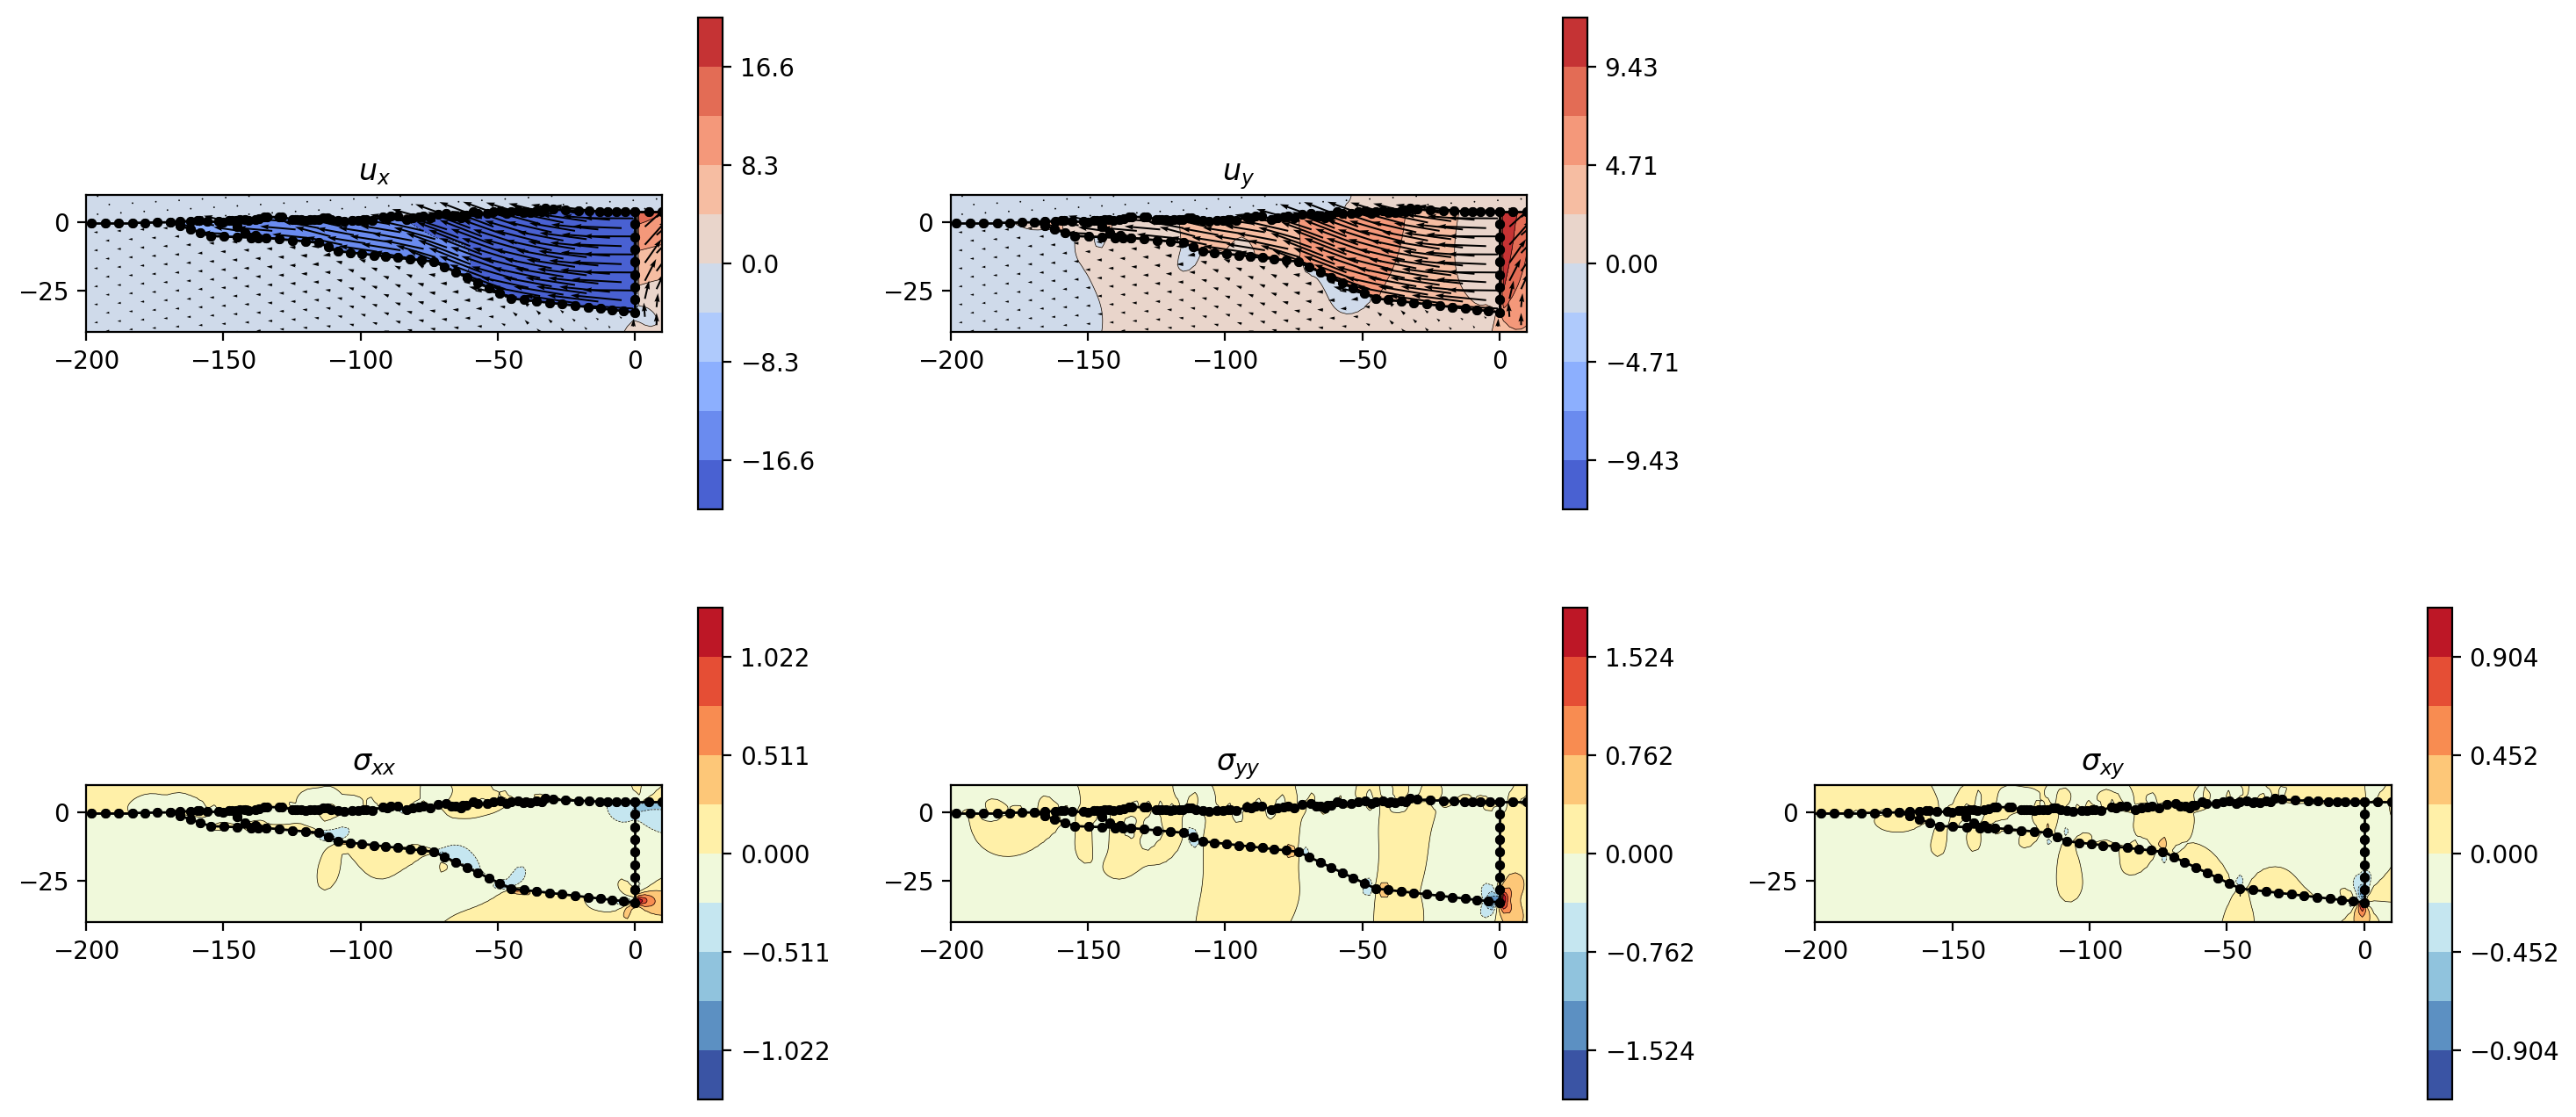

conversion='plane_strain'
[[ 0.375 -0.125  0.   ]
 [-0.125  0.375  0.   ]
 [ 0.     0.     1.   ]]


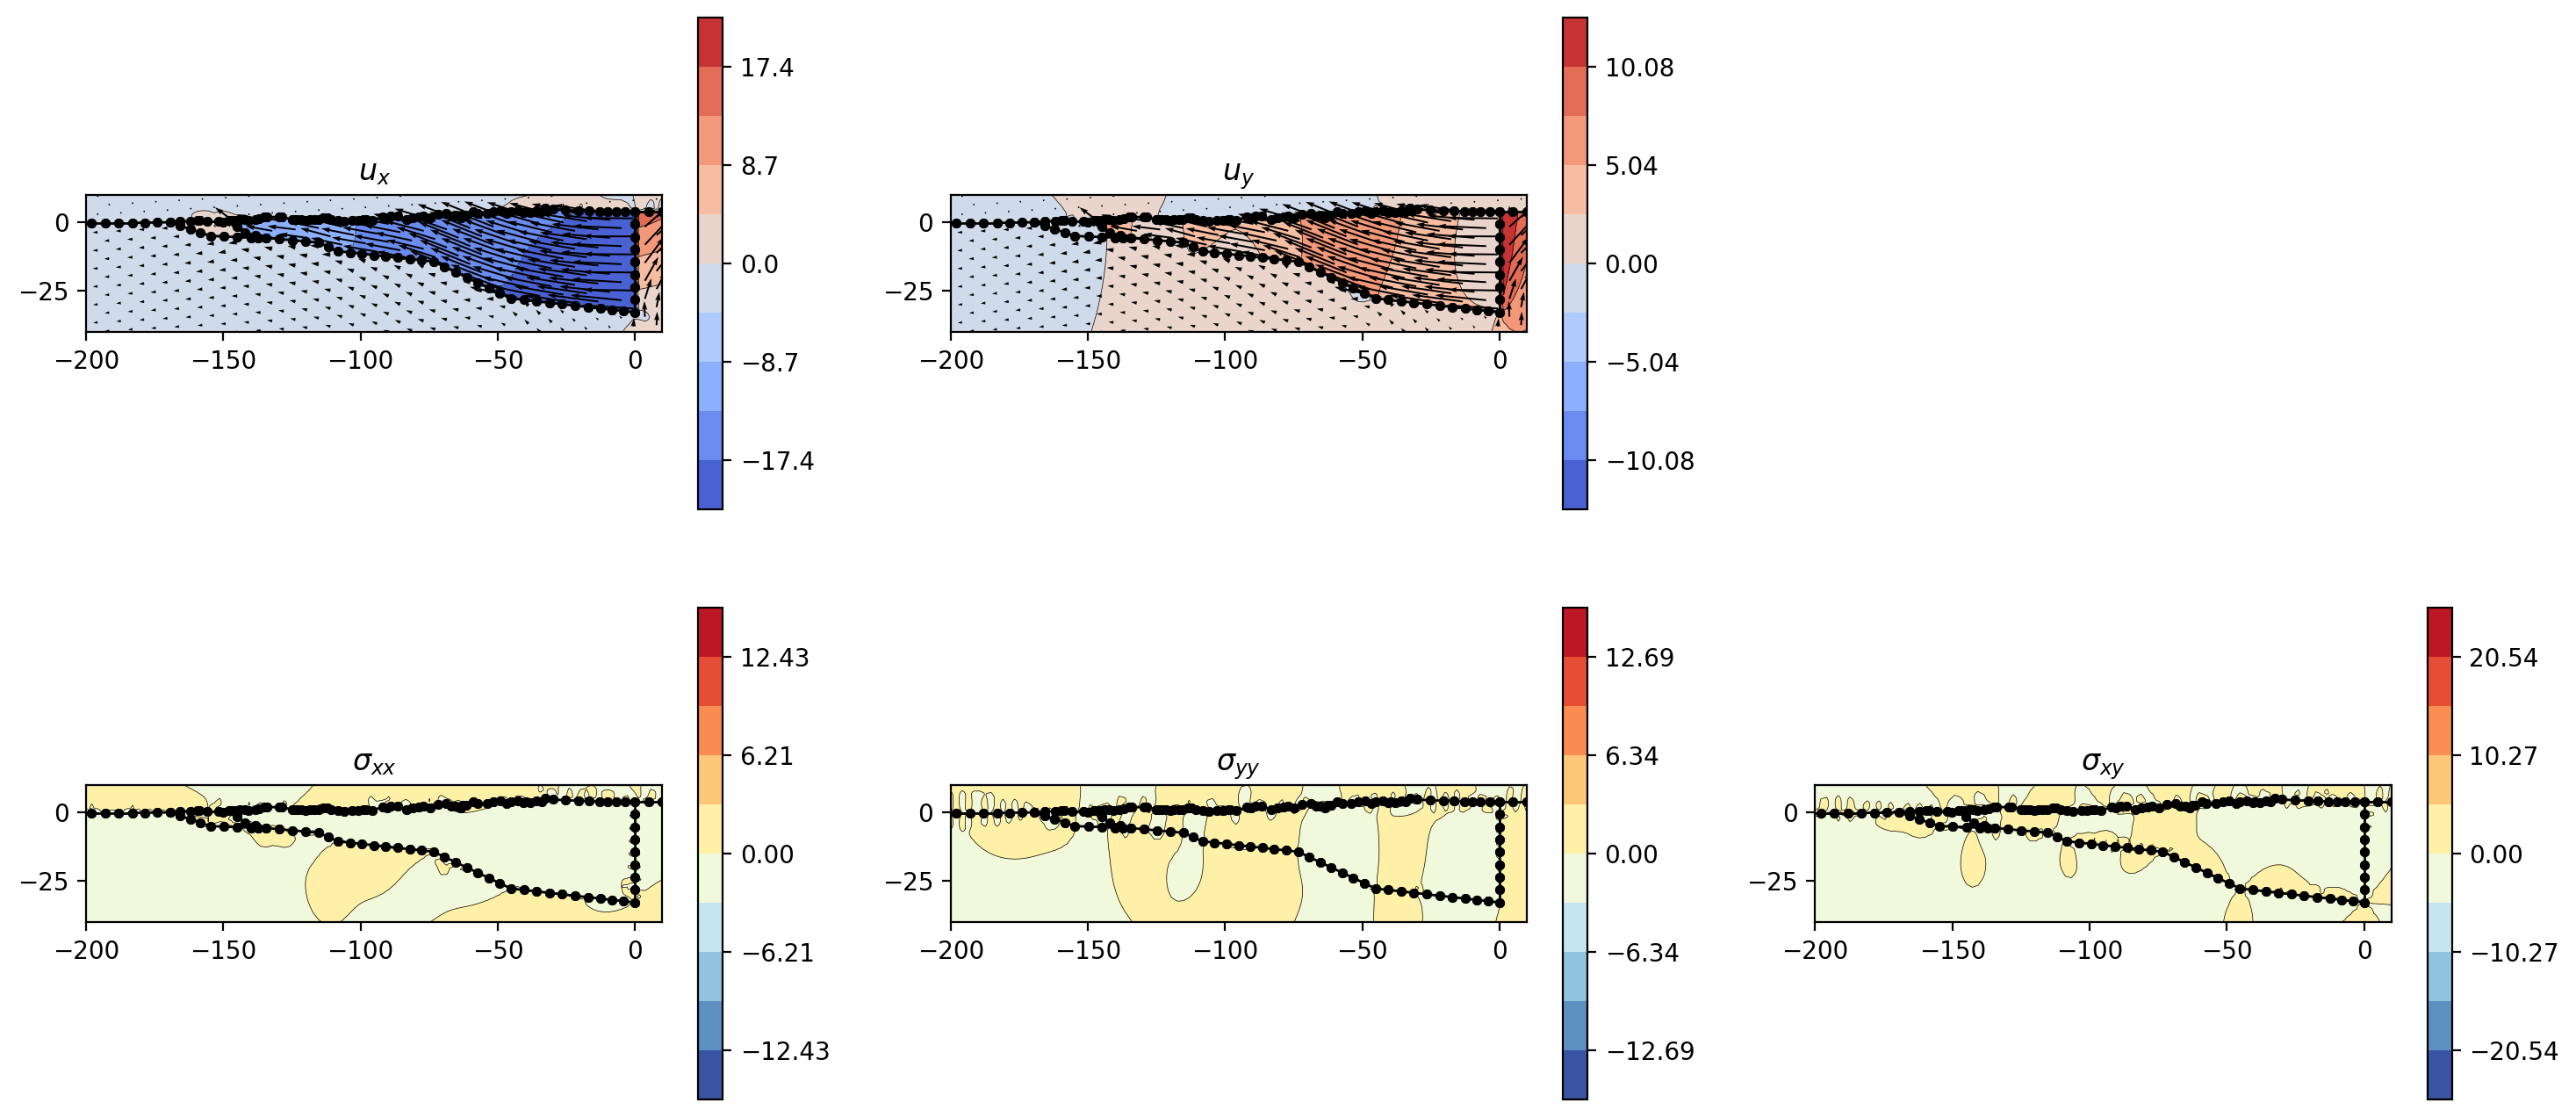

conversion='plane_strain'
[[ 0.375 -0.125  0.   ]
 [-0.125  0.375  0.   ]
 [ 0.     0.     1.   ]]


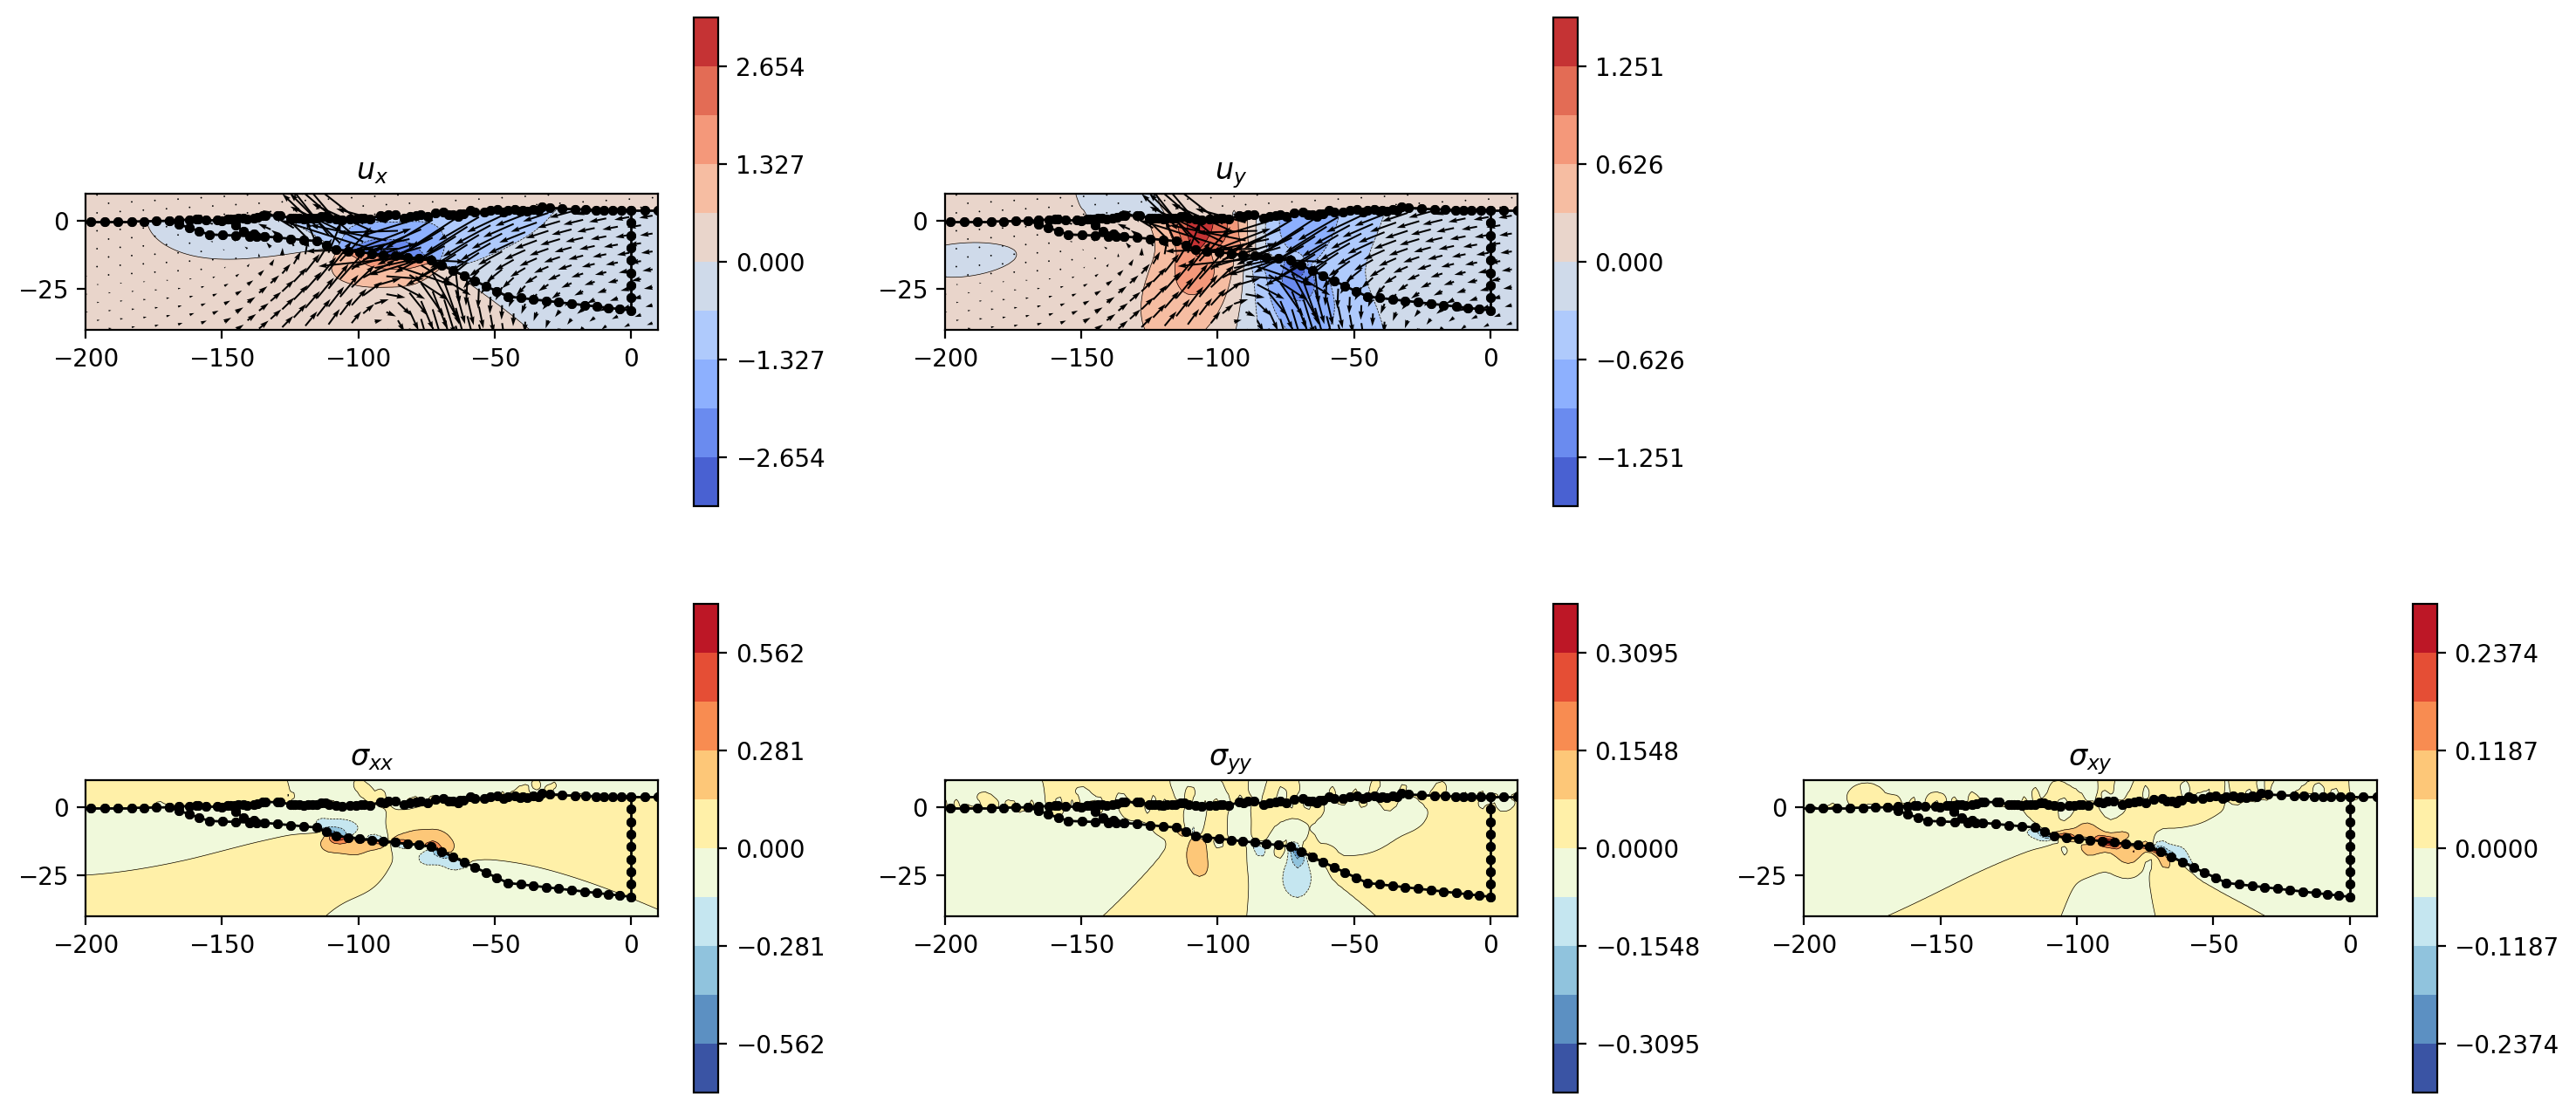

conversion='plane_strain'
[[ 0.375 -0.125  0.   ]
 [-0.125  0.375  0.   ]
 [ 0.     0.     1.   ]]


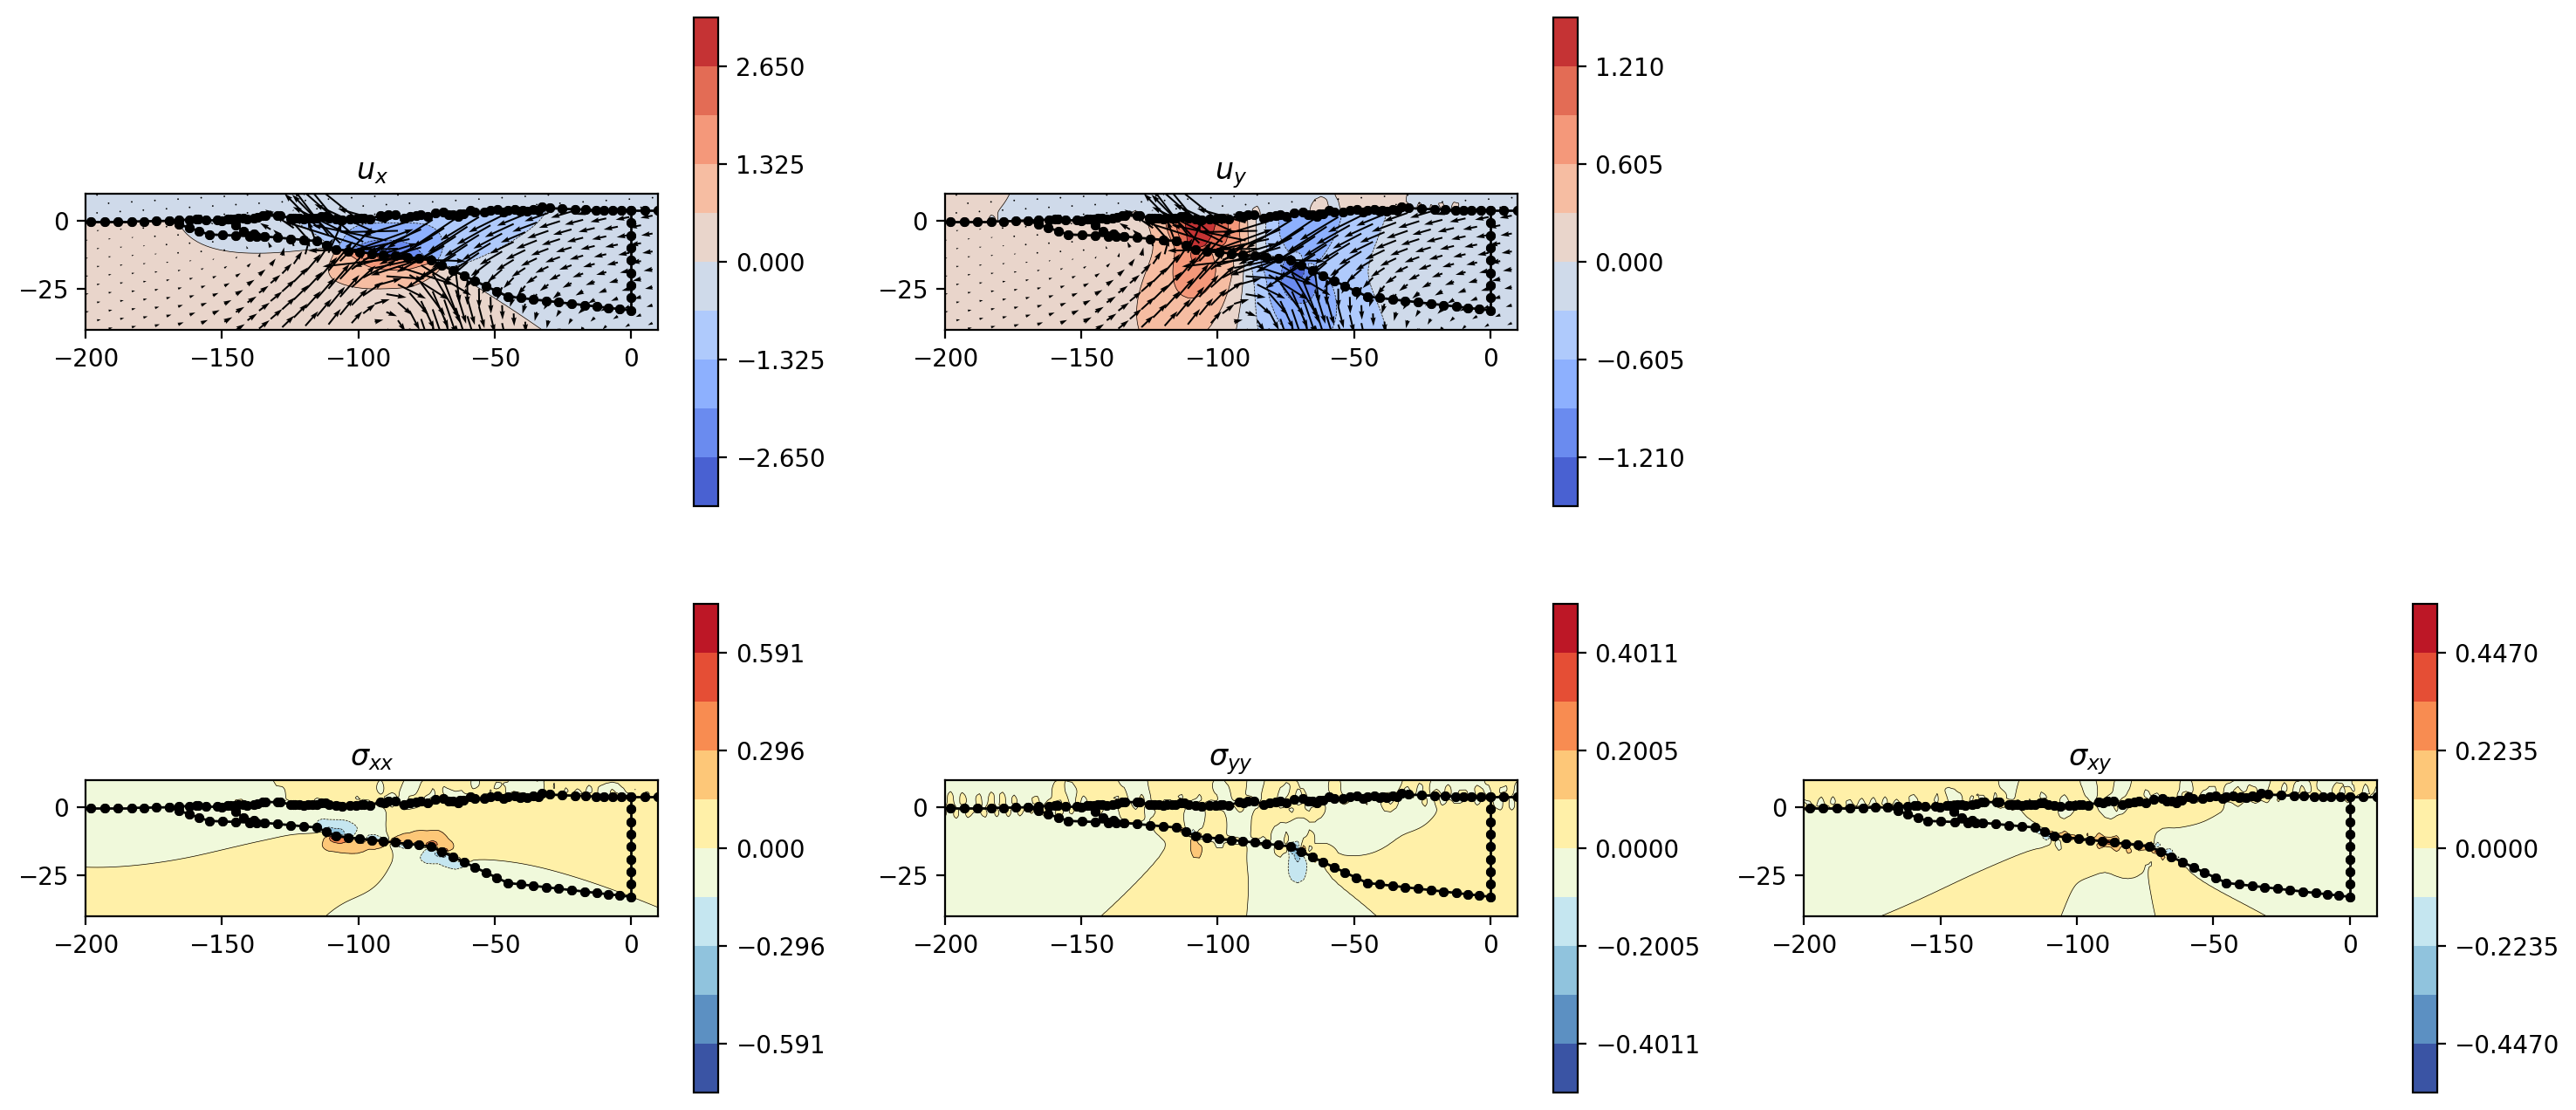

In [5]:
# Observation points
n_obs = 100
x_obs = np.linspace(-200, 10, n_obs)
y_obs = np.linspace(-40, 10, n_obs)
x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# 1. Interseismic (smooth slip)
(
    ux_interseismic_smooth,
    uy_interseismic_smooth,
    sxx_interseismic_smooth,
    syy_interseismic_smooth,
    sxy_interseismic_smooth,
    u_interseismic_smooth,
) = evaluate_bem_solution(x_obs, y_obs, els, mu, nu, coefs_interseismic_smooth)
bemcs.plot_displacements_stresses_els(
    els,
    n_obs,
    ux_interseismic_smooth,
    uy_interseismic_smooth,
    sxx_interseismic_smooth,
    syy_interseismic_smooth,
    sxy_interseismic_smooth,
    x_obs,
    y_obs,
    n_skip_plot=26,
)

# 2. Interseismic (constant slip)
(
    ux_interseismic_constant,
    uy_interseismic_constant,
    sxx_interseismic_constant,
    syy_interseismic_constant,
    sxy_interseismic_constant,
    u_interseismic_constant,
) = evaluate_bem_solution(x_obs, y_obs, els, mu, nu, coefs_interseismic_constant)
bemcs.plot_displacements_stresses_els(
    els,
    n_obs,
    ux_interseismic_constant,
    uy_interseismic_constant,
    sxx_interseismic_constant,
    syy_interseismic_constant,
    sxy_interseismic_constant,
    x_obs,
    y_obs,
    n_skip_plot=26,
)

# 3. Coseismic (smooth slip)
(
    ux_coseismic_smooth,
    uy_coseismic_smooth,
    sxx_coseismic_smooth,
    syy_coseismic_smooth,
    sxy_coseismic_smooth,
    u_coseismic_smooth,
) = evaluate_bem_solution(x_obs, y_obs, els, mu, nu, coefs_coseismic_smooth)
bemcs.plot_displacements_stresses_els(
    els,
    n_obs,
    ux_coseismic_smooth,
    uy_coseismic_smooth,
    sxx_coseismic_smooth,
    syy_coseismic_smooth,
    sxy_coseismic_smooth,
    x_obs,
    y_obs,
    n_skip_plot=26,
)

# 4. Interseismic (constant slip)
(
    ux_coseismic_constant,
    uy_coseismic_constant,
    sxx_coseismic_constant,
    syy_coseismic_constant,
    sxy_coseismic_constant,
    u_coseismic_constant,
) = evaluate_bem_solution(x_obs, y_obs, els, mu, nu, coefs_coseismic_constant)
bemcs.plot_displacements_stresses_els(
    els,
    n_obs,
    ux_coseismic_constant,
    uy_coseismic_constant,
    sxx_coseismic_constant,
    syy_coseismic_constant,
    sxy_coseismic_constant,
    x_obs,
    y_obs,
    n_skip_plot=26,
)

# Read in wedge geometry polygon and set up spatial filter

In [8]:
df = pd.read_csv("mht_wedge_polygon.csv")
inpolygon_vals = bemcs.inpolygon(
    x_obs.flatten(), y_obs.flatten(), df.x.values, df.y.values
)
inpolygon_vals = np.reshape(inpolygon_vals, (n_obs, n_obs))

# Pretty plotting of coseismic internal strain energy
1. Constant slip case
2. Smooth slip case
3. Residual (constant - smooth)

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_53165/1131141741.py:25: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_53165/1131141741.py:64: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_53165/1131141741.py:103: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(


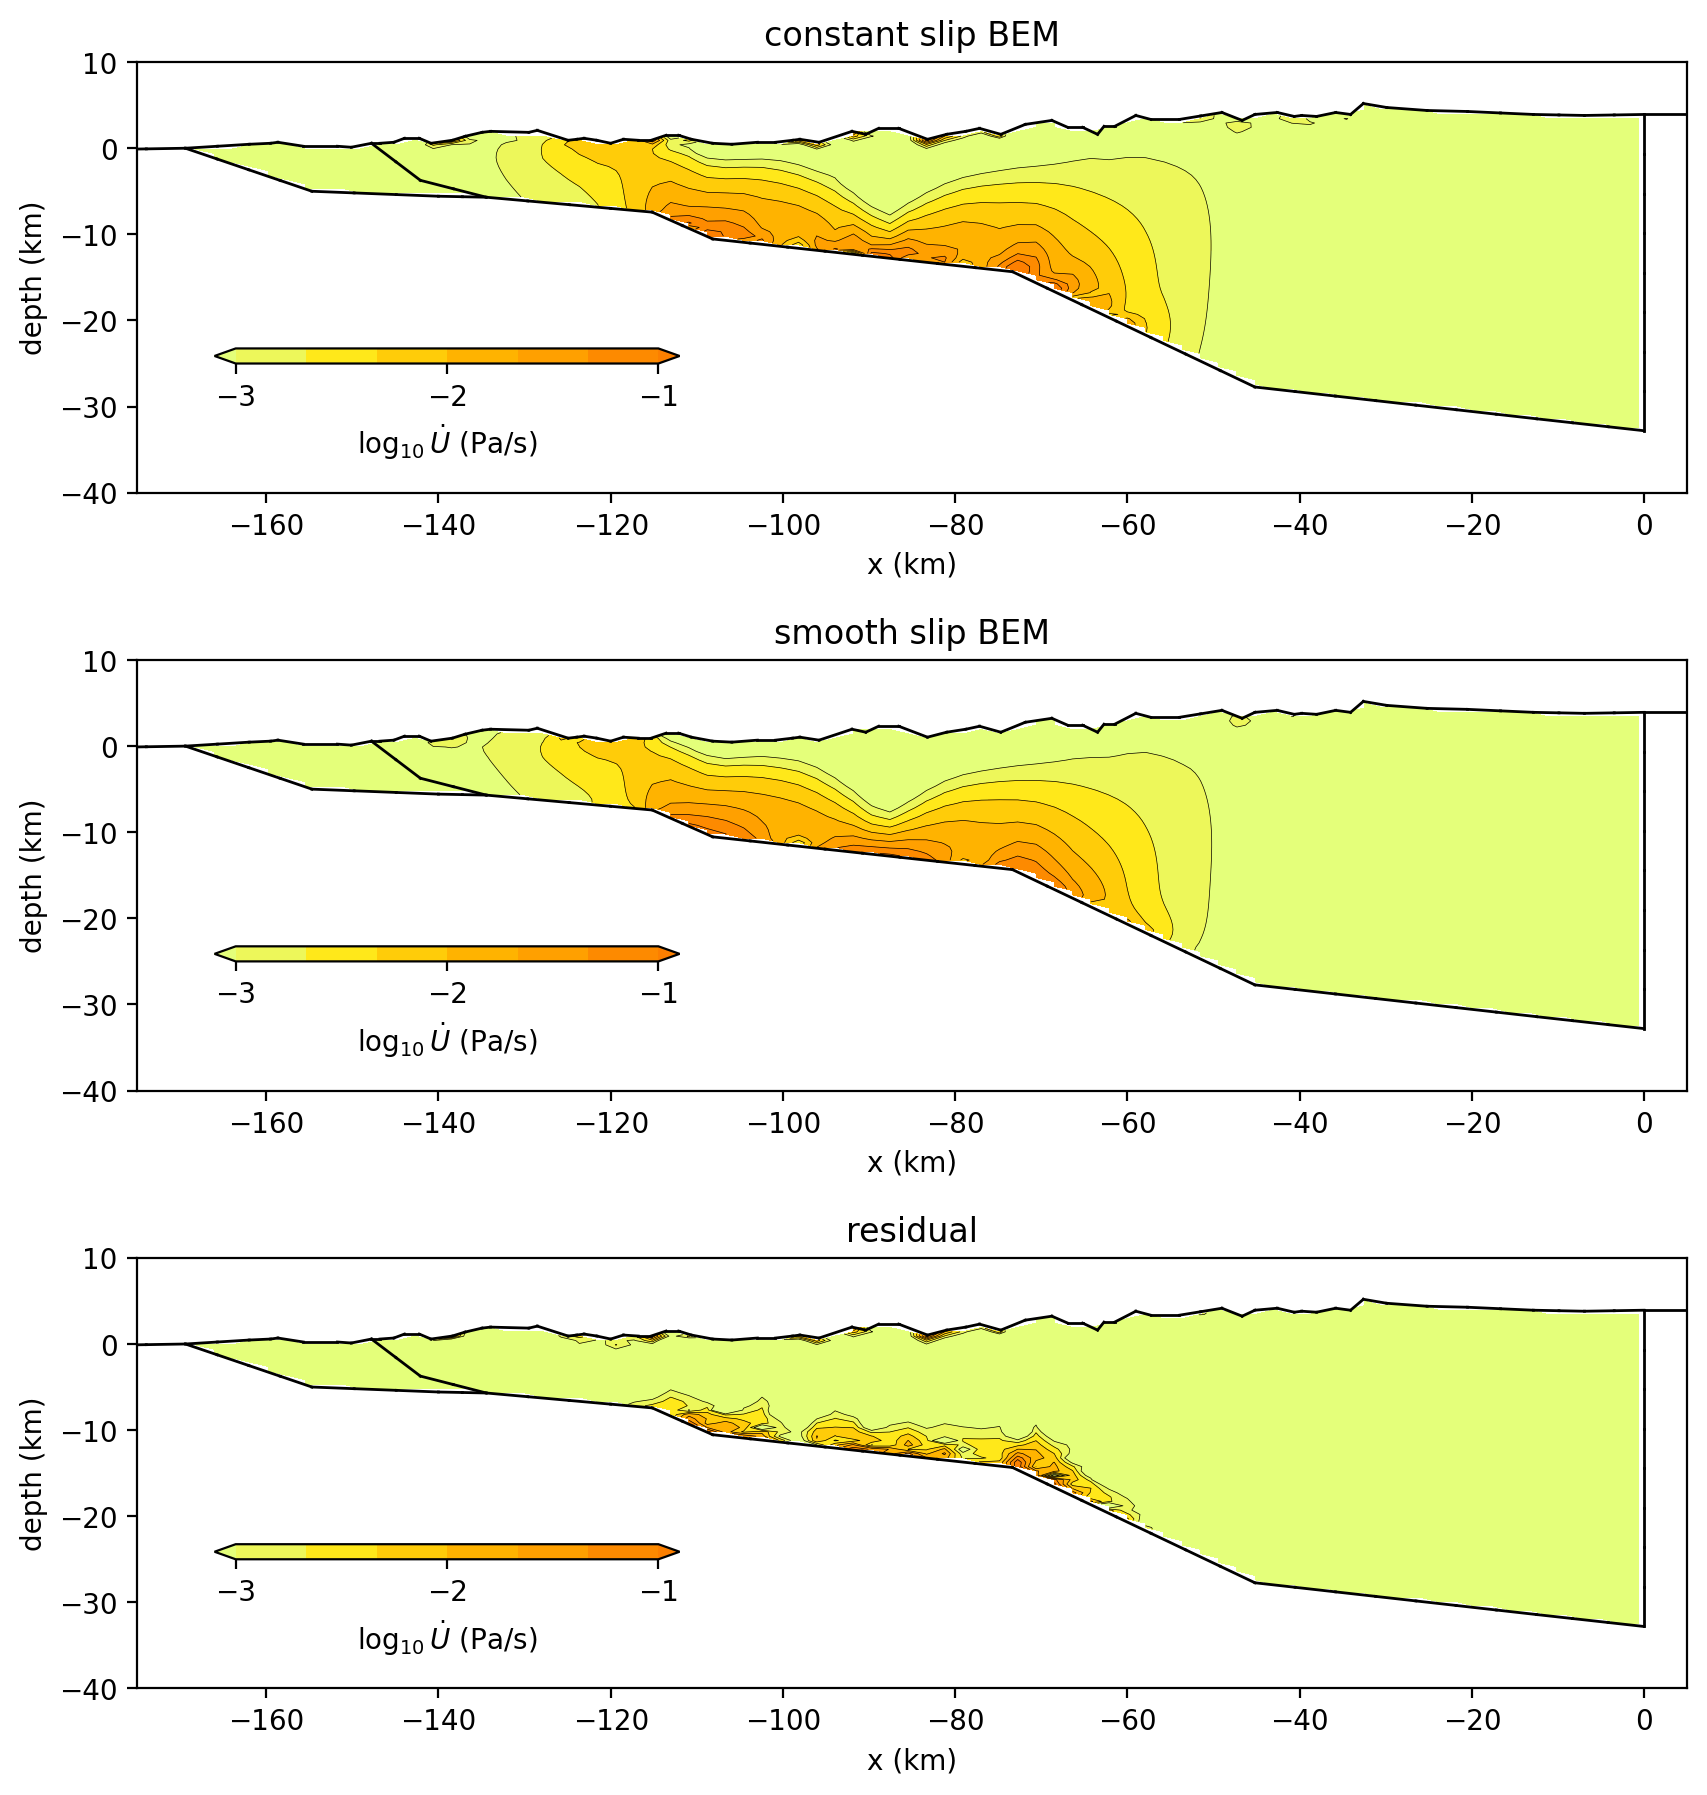

In [14]:
# plt.figure(figsize=(10, 7))
plt.figure(figsize=(10, 11))

# Constant slip
plt.subplot(3, 1, 1)
to_plot = u_coseismic_constant.reshape(n_obs, n_obs)
to_plot = np.log10(to_plot)
to_plot[~inpolygon_vals] = np.nan
levels = np.linspace(-3, -1, 7)

plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    to_plot,
    cmap="Wistia",
    extend="both",
    levels=levels,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.05, 0.30, 0.3, 0.035)),
    orientation="horizontal",
    label="$\log_{10} \dot{U}$ (Pa/s)",
)
cb.set_ticks([-3, -2, -1])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    to_plot,
    linewidths=0.25,
    colors="k",
    levels=levels,
    linestyles="-",
    linewidth=0.25,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-", linewidth=1.0)
plt.xlim([-175, 5])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x (km)")
plt.ylabel("depth (km)")
plt.title("constant slip BEM")

# Smooth slip
plt.subplot(3, 1, 2)
to_plot = u_coseismic_smooth.reshape(n_obs, n_obs)
to_plot = np.log10(to_plot)
to_plot[~inpolygon_vals] = np.nan
levels = np.linspace(-3, -1, 7)
plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    to_plot,
    cmap="Wistia",
    extend="both",
    levels=levels,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.05, 0.30, 0.3, 0.035)),
    orientation="horizontal",
    label="$\log_{10} \dot{U}$ (Pa/s)",
)
cb.set_ticks([-3, -2, -1])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    to_plot,
    linewidths=0.25,
    colors="k",
    levels=levels,
    linestyles="-",
    linewidth=0.25,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-", linewidth=1.0)
plt.xlim([-175, 5])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x (km)")
plt.ylabel("depth (km)")
plt.title("smooth slip BEM")

# Ressidual
plt.subplot(3, 1, 3)
to_plot = u_coseismic_constant.reshape(n_obs, n_obs) - u_coseismic_smooth.reshape(
    n_obs, n_obs
)
to_plot = np.log10(np.abs(to_plot))
to_plot[~inpolygon_vals] = np.nan
levels = np.linspace(-3, -1, 7)
plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    to_plot,
    cmap="Wistia",
    extend="both",
    levels=levels,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.05, 0.30, 0.3, 0.035)),
    orientation="horizontal",
    label="$\log_{10} \dot{U}$ (Pa/s)",
)
cb.set_ticks([-3, -2, -1])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    to_plot,
    linewidths=0.25,
    colors="k",
    levels=levels,
    linestyles="-",
    linewidth=0.25,
)
for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-", linewidth=1.0)
plt.xlim([-175, 5])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x (km)")
plt.ylabel("depth (km)")
plt.title("residual")


# plt.savefig("mht_internal_strain_energy_constant.png", dpi=500)
# plt.savefig("mht_internal_strain_energy_constant.pdf")
plt.show()

# Plot first stress invariant

In [ ]:
plt.figure(figsize=(10, 7))

# Constant
plt.subplot(2, 1, 1)
toplot = (constant_sxx + constant_syy).reshape(n_obs, n_obs)
toplot[~inpolygon_vals] = np.nan
levels = np.linspace(-1.0, 1.0, 20)

plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="bwr",
    extend="both",
    levels=levels,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.05, 0.30, 0.3, 0.035)),
    orientation="horizontal",
    label="$\mathrm{I}_{1}$ (Pa/s)",
)
cb.set_ticks([-1, 0, 1])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    linewidths=0.25,
    colors="k",
    levels=levels,
    linestyles="-",
)

for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-", linewidth=1.0)

plt.xlim([-175, 5])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x (km)")
plt.ylabel("depth (km)")
plt.title("smooth slip BEM")


plt.title("constant slip BEM")

# Quadratic
plt.subplot(2, 1, 2)
toplot = (sxx + syy).reshape(n_obs, n_obs)
toplot[~inpolygon_vals] = np.nan
levels = np.linspace(-1.0, 1.0, 20)

plt.contourf(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    cmap="bwr",
    extend="both",
    levels=levels,
)
cb = plt.colorbar(
    cax=plt.gca().inset_axes((0.05, 0.30, 0.3, 0.035)),
    orientation="horizontal",
    label="$\mathrm{I}_{1}$ (Pa/s)",
)
cb.set_ticks([-1, 0, 1])
plt.contour(
    x_obs.reshape(n_obs, n_obs),
    y_obs.reshape(n_obs, n_obs),
    toplot,
    linewidths=0.25,
    colors="k",
    levels=levels,
    linestyles="-",
)

for i in range(n_els):
    plt.plot([els.x1[i], els.x2[i]], [els.y1[i], els.y2[i]], "k-", linewidth=1.0)

plt.xlim([-175, 5])
plt.ylim([np.min(y_obs), np.max(y_obs)])
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x (km)")
plt.ylabel("depth (km)")
plt.title("smooth slip BEM")

# plt.savefig("mht_internal_I1_constant.png", dpi=500)
# plt.savefig("mht_internal_I1_constant.pdf")
plt.show()